# PINN vs Analytical Solution: 3D Time-Dependent Schrödinger Equation

This notebook:

1. Defines and trains the PINN model
2. Defines the analytical solution for a particle in a cubic box
3. Compares model predictions vs. the exact solution on a fixed slice

Epoch 200, Loss: 1.173e-03
Epoch 400, Loss: 2.131e-03
Epoch 600, Loss: 2.271e-03
Epoch 800, Loss: 2.358e-03
Epoch 1000, Loss: 2.413e-03
Epoch 1200, Loss: 5.160e-04
Epoch 1400, Loss: 1.779e-03
Epoch 1600, Loss: 1.994e-03
Epoch 1800, Loss: 8.309e-04
Epoch 2000, Loss: 1.474e-03
Epoch 2200, Loss: 8.791e-04
Epoch 2400, Loss: 2.632e-03
Epoch 2600, Loss: 2.614e-03
Epoch 2800, Loss: 2.138e-03
Epoch 3000, Loss: 2.340e-03
Epoch 3200, Loss: 1.841e-03
Epoch 3400, Loss: 1.831e-03
Epoch 3600, Loss: 6.496e-04
Epoch 3800, Loss: 1.346e-03
Epoch 4000, Loss: 1.888e-03
Epoch 4200, Loss: 9.780e-04
Epoch 4400, Loss: 1.887e-03
Epoch 4600, Loss: 1.178e-03
Epoch 4800, Loss: 1.435e-03
Epoch 5000, Loss: 2.547e-03
Epoch 5200, Loss: 1.631e-03
Epoch 5400, Loss: 7.715e-04
Epoch 5600, Loss: 1.180e-03
Epoch 5800, Loss: 1.572e-03
Epoch 6000, Loss: 6.933e-04
Epoch 6200, Loss: 1.063e-03
Epoch 6400, Loss: 3.021e-03
Epoch 6600, Loss: 1.973e-03
Epoch 6800, Loss: 2.303e-03
Epoch 7000, Loss: 2.376e-03
Epoch 7200, Loss: 1.715e

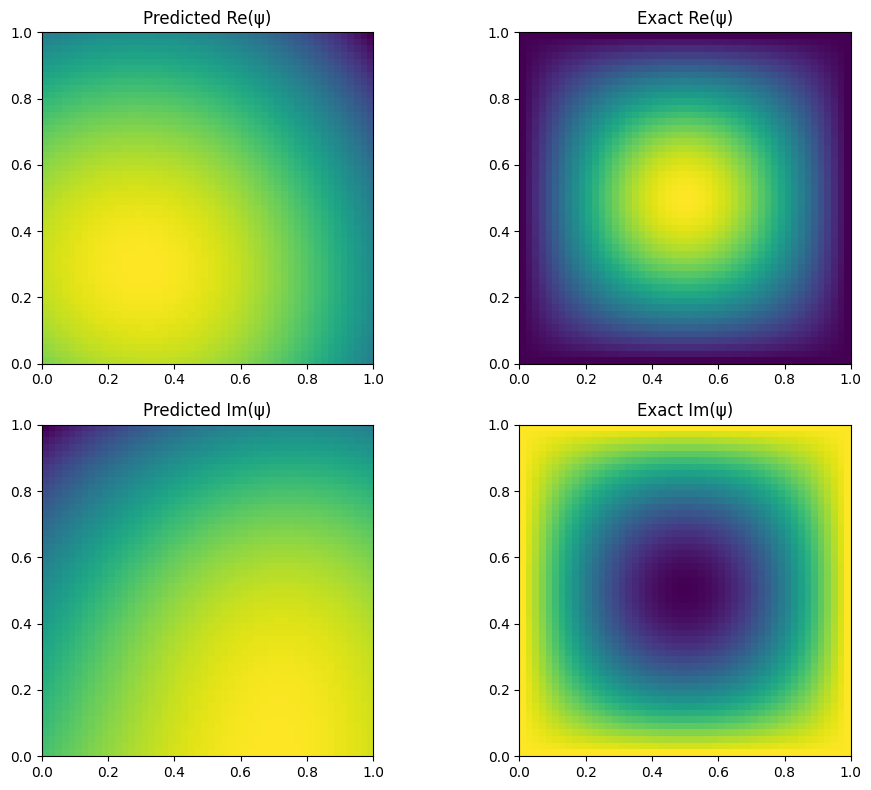

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# For reproducibility
torch.manual_seed(0)

# Model definition (copy from template)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

class SchrodingerPINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
        self.apply(init_weights)

    def forward(self, X):
        u = X
        for layer in self.layers[:-1]:
            u = self.activation(layer(u))
        return self.layers[-1](u)

# Residual
def schrodinger_residual(model, x, y, z, t, V_func, hbar=1.0, m=1.0):
    # ensure each input requires grad
    x = x.clone().detach().requires_grad_(True)
    y = y.clone().detach().requires_grad_(True)
    z = z.clone().detach().requires_grad_(True)
    t = t.clone().detach().requires_grad_(True)

    X = torch.cat([x, y, z, t], dim=1).requires_grad_(True)
    psi = model(X)
    psi_r, psi_i = psi[:,0:1], psi[:,1:2]
    psi_r_t = autograd.grad(psi_r, t, torch.ones_like(psi_r), create_graph=True)[0]
    psi_i_t = autograd.grad(psi_i, t, torch.ones_like(psi_i), create_graph=True)[0]
    grads = {}
    for name, comp in [('r', psi_r), ('i', psi_i)]:
        comp_x = autograd.grad(comp, x, torch.ones_like(comp), create_graph=True)[0]
        comp_xx = autograd.grad(comp_x, x, torch.ones_like(comp_x), create_graph=True)[0]
        comp_y = autograd.grad(comp, y, torch.ones_like(comp), create_graph=True)[0]
        comp_yy = autograd.grad(comp_y, y, torch.ones_like(comp_y), create_graph=True)[0]
        comp_z = autograd.grad(comp, z, torch.ones_like(comp), create_graph=True)[0]
        comp_zz = autograd.grad(comp_z, z, torch.ones_like(comp_z), create_graph=True)[0]
        grads[f'{name}_lap'] = comp_xx + comp_yy + comp_zz
    V = V_func(x, y, z)
    res_r = hbar * psi_i_t + (hbar**2/(2*m)) * grads['r_lap'] - V * psi_r
    res_i = -hbar * psi_r_t + (hbar**2/(2*m)) * grads['i_lap'] - V * psi_i
    return res_r, res_i

# Sampling
def sample_domain(N, L, T):
    x = torch.rand(N,1)*L
    y = torch.rand(N,1)*L
    z = torch.rand(N,1)*L
    t = torch.rand(N,1)*T
    return x, y, z, t

def sample_initial(N, L):
    x = torch.rand(N,1)*L
    y = torch.rand(N,1)*L
    z = torch.rand(N,1)*L
    t = torch.zeros_like(x)
    return x, y, z, t

# Parameters
L, T = 1.0, 1.0

# Potential & initial
def V_func(x, y, z):
    return torch.zeros_like(x)

def psi_initial(x, y, z):
    return torch.exp(-((x-0.5*L)**2 + (y-0.5*L)**2 + (z-0.5*L)**2)/(0.1**2))

# Build and train
model = SchrodingerPINN([4, 100, 100, 100, 2])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10000  # reduced for demo
for epoch in range(1, epochs+1):
    x_r, y_r, z_r, t_r = sample_domain(2000, L, T)
    res_r, res_i = schrodinger_residual(model, x_r, y_r, z_r, t_r, V_func)
    loss_pde = (res_r**2 + res_i**2).mean()
    x_i, y_i, z_i, t_i = sample_initial(1000, L)
    psi0 = psi_initial(x_i, y_i, z_i)
    psi_pred = model(torch.cat([x_i, y_i, z_i, t_i], dim=1))
    psi_r0, psi_i0 = psi_pred[:,0:1], psi_pred[:,1:2]
    loss_ic = ((psi_r0 - psi0)**2 + psi_i0**2).mean()
    loss = loss_pde + loss_ic
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.3e}")

# Define analytical solution (ground state only)
hbar = 1.0
m = 1.0
E111 = (3 * np.pi**2 * hbar**2) / (2*m * L**2)
def psi_exact(x, y, z, t):
    val = np.sin(np.pi*x/L)*np.sin(np.pi*y/L)*np.sin(np.pi*z/L)
    return val * np.exp(-1j * E111 * t / hbar)

# Prepare comparison at t = 0.5, z = L/2
t_plot = 0.5
z0 = L/2
n = 50
xs = np.linspace(0, L, n)
ys = np.linspace(0, L, n)
X, Y = np.meshgrid(xs, ys)
x_flat = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
y_flat = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)
z_flat = torch.full_like(x_flat, z0)
t_flat = torch.full_like(x_flat, t_plot)
with torch.no_grad():
    psi_pred = model(torch.cat([x_flat, y_flat, z_flat, t_flat], dim=1)).numpy().reshape(-1,2)
psi_r_pred = psi_pred[:,0].reshape(n,n)
psi_i_pred = psi_pred[:,1].reshape(n,n)
psi_ex = psi_exact(X, Y, z0, t_plot)
psi_r_ex = psi_ex.real
psi_i_ex = psi_ex.imag

# Plot
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs[0,0].imshow(psi_r_pred, extent=[0,L,0,L], origin='lower')
axs[0,0].set_title('Predicted Re(ψ)')
axs[0,1].imshow(psi_r_ex, extent=[0,L,0,L], origin='lower')
axs[0,1].set_title('Exact Re(ψ)')
axs[1,0].imshow(psi_i_pred, extent=[0,L,0,L], origin='lower')
axs[1,0].set_title('Predicted Im(ψ)')
axs[1,1].imshow(psi_i_ex, extent=[0,L,0,L], origin='lower')
axs[1,1].set_title('Exact Im(ψ)')
plt.tight_layout()
plt.show()

**End of notebook.**